### Содержание

1. [Подготовка датафреймов](#Подготовка-датафреймов)  
   1.1 [Фильтруем общий датафрейм](#Фильтруем-общий-датафрейм)  
   1.2 [Добавляем метрику LOEUF](#Добавляем-метрику-LOEUF)  
   1.3 [Добавляем метрику pext](#Добавляем-метрику-pext)  
   1.4 [Получение NMD(-) регионов](#Получение-NMD(-)-регионов)  
   1.5 [Добавление статуса NMD в датафрейм](#Добавление-статуса-NMD-в-датафрейм)  
3. [Разделение на NMD(+) и NMD(-) датафреймы](#Разделение-на-NMD(+)-и-NMD(-)-датафреймы)  
4. [Разделение вариантов по значению патогенности](#Разделение-вариантов-по-значению-патогенности)  
   3.1 [Разделение по AC](#Разделение-по-AC)  
   3.2 [Обработка датафрейма Clinvar](#Обработка-датафрейма-Clinvar)  
   3.3 [Убираем из условно доброкачественных вариантов все паты по Clinvar](#Убираем-из-условно-доброкачественных-вариантов-все-паты-Clinvar)  
   3.4 [Добавляем в условно патогенные варианты все непопуляционные паты Clinvar](#Добавляем-в-условно-патогенные-варианты-все-непопуляционные-паты-Clinvar)
5. [Сбалансируем датафреймы](#Сбалансируем-датафреймы)
6. [Посмотрим на распределение кДНК позиций относительно начала и конца транскриптов](#Посмотрим-на-распределение-кДНК-позиций-относительно-начала-и-конца-транскриптов)  
7. [Получение контекста последовательности](#Получение-контекста-последовательности)
8. [Проверим, точно ли всё правильно сделали при обработке датафреймов](#Проверим,-точно-ли-всё-правильно-сделали-при-обработке-датафреймов)  
9. [Построение лого с помощью logomaker](#Построение-лого-с-помощью-logomaker)  
10. [Статистическое сравнение позиций в контекстах](#Статистическое-сравнение-позиций-в-контекстах)  

In [1]:
import datetime
import json
import logomaker as lm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo

from pyfaidx import Fasta
from scipy.stats import chi2_contingency
from os.path import join

**В этом ноутбуке представлены результаты для вариантов, которые <font color="red"> избегают </font>NMD.**

### Подготовка датафреймов

Преобразуем имеющиеся таблицы tsv в датафреймы и объединяем всё в один датафрейм.

In [2]:
DATA_PATH = "data_dir/canonical_ensemble"

In [3]:
chromosomes = ['chr' + str(i) for i in range(1, 23)]  # только аутосомы
frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]

all_chrom_df = pd.concat(frames)

/tmp/ipykernel_1417270/2292932966.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1417270/2292932966.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1417270/2292932966.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1417270/2292932966.py:2: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exom

In [4]:
all_chrom_df.shape

(67528142, 14)

In [5]:
all_chrom_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Impact                  object
Consequence             object
Gene_symbol             object
Canonical_transcript    object
cDNA_position           object
LoF                     object
LoF_flag                object
LoF_filter              object
AC                       int64
dtype: object

In [6]:
all_chrom_df = all_chrom_df.rename(columns={'Chr': 'CHROM', 'Position': 'POS', 'Ref': 'REF', 'Alt': 'ALT'})

In [7]:
all_chrom_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
0,chr1,12541,.,C,G,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,1
1,chr1,12591,rs1553119381,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
2,chr1,12592,.,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
3,chr1,12599,rs1437963543,CT,C,"LOW, MODIFIER, MODIFIER",splice_polypyrimidine_tract_variant&intron_var...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,14
4,chr1,12612,rs1205998786,GGT,G,"LOW, MODIFIER, MODIFIER",splice_region_variant&non_coding_transcript_ex...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",98-99,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621633,chr22,50799702,rs4081531,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,377
1621634,chr22,50799821,rs149733995,A,C,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,11
1621635,chr22,50801218,rs368061391,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,1
1621636,chr22,50801236,rs113976139,C,G,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,18


#### Фильтруем общий датафрейм

Оставляем только однонуклеотидные стопгейны.

In [8]:
lof_final_df = all_chrom_df[all_chrom_df['Consequence'] == 'stop_gained']
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


Удалим все строки, где нет названия транскрипта в "Canonical_transcript" или там стоит два и больше названий:

In [9]:
lof_final_df = lof_final_df.dropna(subset=['Canonical_transcript'])
lof_final_df = lof_final_df[~lof_final_df['Canonical_transcript'].str.contains(',')]

In [10]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


Удалим строки, где есть LOF-флаги:

In [11]:
lof_final_df['LoF_flag'].unique()

array([nan, 'PHYLOCSF_WEAK', 'SINGLE_EXON', 'SINGLE_EXON,PHYLOCSF_WEAK',
       'PHYLOCSF_UNLIKELY_ORF'], dtype=object)

In [12]:
lof_final_df = lof_final_df[lof_final_df['LoF_flag'].isnull()]

In [13]:
lof_final_df['LoF_flag'].unique()

array([nan], dtype=object)

In [14]:
lof_final_df['Consequence'].unique()

array(['stop_gained'], dtype=object)

In [15]:
lof_final_df['POS'].nunique()

242454

#### Добавляем метрику LOEUF

The loss-of-function observed over expected upper bound fraction, or LOEUF score, is a metric that places each gene on a continuous scale of loss-of-function constraint. Low scores are highly correlated with disease genes and gene essentiality (https://doi.org/10.1007/s00439-022-02509-x). 
  
Due to expected shifts in the LOEUF distribution between gnomAD v2.1.1 and v4.0, we now recommend a threshold of LOEUF < 0.6 for v4.0 (compared to LOEUF < 0.35 for v2). (https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/#loeuf-guidance)

Для этого сначала переводим скачанный файл с метриками в датафрейм.

In [16]:
lof_metrics_by_gene = pd.read_table('../raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
lof_metrics_by_gene

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,...,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,...,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,protein_coding,1038,7.093800e-03,3.0,2.9635,1.012300,NaN,19,9212945,9213982
19700,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,protein_coding,939,4.059600e-01,1.0,4.8401,0.206610,NaN,19,9236688,9237626
19701,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,protein_coding,1026,2.159200e-01,1.0,2.7436,0.364480,NaN,11,124179708,124180733
19702,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,protein_coding,22597,1.477300e-13,16.0,9.6420,1.659400,NaN,19,53267448,53290044


In [17]:
lof_metrics_by_gene.columns

Index(['gene', 'transcript', 'obs_mis', 'exp_mis', 'oe_mis', 'mu_mis',
       'possible_mis', 'obs_mis_pphen', 'exp_mis_pphen', 'oe_mis_pphen',
       'possible_mis_pphen', 'obs_syn', 'exp_syn', 'oe_syn', 'mu_syn',
       'possible_syn', 'obs_lof', 'mu_lof', 'possible_lof', 'exp_lof', 'pLI',
       'pNull', 'pRec', 'oe_lof', 'oe_syn_lower', 'oe_syn_upper',
       'oe_mis_lower', 'oe_mis_upper', 'oe_lof_lower', 'oe_lof_upper',
       'constraint_flag', 'syn_z', 'mis_z', 'lof_z', 'oe_lof_upper_rank',
       'oe_lof_upper_bin', 'oe_lof_upper_bin_6', 'n_sites', 'classic_caf',
       'max_af', 'no_lofs', 'obs_het_lof', 'obs_hom_lof', 'defined', 'p',
       'exp_hom_lof', 'classic_caf_afr', 'classic_caf_amr', 'classic_caf_asj',
       'classic_caf_eas', 'classic_caf_fin', 'classic_caf_nfe',
       'classic_caf_oth', 'classic_caf_sas', 'p_afr', 'p_amr', 'p_asj',
       'p_eas', 'p_fin', 'p_nfe', 'p_oth', 'p_sas', 'transcript_type',
       'gene_id', 'transcript_level', 'cds_length', 'num_codi

In [18]:
lof_metrics_by_gene.columns.get_loc('oe_lof_upper')

29

Создаем словарь "транскрипт": "значение_loeuf".

In [19]:
loeuf_by_transcript_dict = dict(zip(lof_metrics_by_gene['transcript'], lof_metrics_by_gene['oe_lof_upper']))

In [20]:
# loeuf_by_transcript_dict

Запишем в столбец LOEUF все совпадения по ключам-транскриптам.

In [21]:
lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)

/tmp/ipykernel_1417270/2571592718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)


In [22]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1,NaN
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1,NaN
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1,NaN
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2,NaN
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173,NaN
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1,NaN
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1,NaN
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2,NaN


Посмотрим, какие значения записались и сверим, совпадает ли с исходным файлом **(upd: да)**

In [23]:
lof_final_df[lof_final_df['LOEUF'].notna()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
13676,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880


In [24]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000327044', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000216139', 'oe_lof_upper'].values[0])

1.327 
 0.88


In [25]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000370783', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000262213', 'oe_lof_upper'].values[0])

0.361 
 0.361


Удалим все строки, где нет LOEUF (т.к. для нас они бессмысленны и всё равно удалятся при делении на пат/бен):

In [26]:
lof_final_df = lof_final_df.dropna(subset=['LOEUF'])

In [27]:
lof_final_df.shape

(170690, 15)

Оставляем только высококонсервативные варианты:

In [28]:
lof_final_df = lof_final_df[lof_final_df['LOEUF'] < 0.35]

In [29]:
lof_final_df.shape

(23366, 15)

#### Добавляем метрику pext

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10029069/

In [30]:
header_pext = ['chrom', 'pos', 'ref', 'alt', 'tx_annotation']

Выгружаем и обрабатываем отфильтрованный файл (внутри только стопгейны):

In [31]:
pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)

/tmp/ipykernel_1417270/4201993334.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)


In [32]:
tx_annotation_data = pext_raw_df['tx_annotation'].apply(lambda x: json.loads(x.replace("'", "\""))[0])
pext_tx_annotation = pd.DataFrame(tx_annotation_data.tolist())
pext_hg19_df = pd.concat([pext_raw_df.drop(columns=['tx_annotation']), pext_tx_annotation], axis=1)

In [33]:
pext_hg19_df = pext_hg19_df[(pext_hg19_df['chrom'] != 'X') & (pext_hg19_df['chrom'] != 'Y')]

In [34]:
pext_hg19_df

,chrom,pos,ref,alt,ensg,csq,symbol,lof,lof_flag,Cells_Transformedfibroblasts,...,Brain_Anteriorcingulatecortex_BA24_,Brain_Putamen_basalganglia_,Brain_Caudate_basalganglia_,Colon_Sigmoid,Cervix_Endocervix,Ovary,Esophagus_GastroesophagealJunction,Testis,Brain_Amygdala,mean_proportion
0,1,69100,G,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,69130,C,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,69133,G,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,69139,C,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,69158,T,A,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190799,22,51220691,A,T,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190800,22,51220695,C,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190801,22,51220704,T,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190802,22,51220710,T,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288


Переводим в hg38:

In [35]:
pext_hg38_df = pext_hg19_df.copy()
pext_hg38_df['chrom'] = pext_hg38_df['chrom'].apply(lambda x: 'chr' + str(x))

In [36]:
pext_hg38_df

,chrom,pos,ref,alt,ensg,csq,symbol,lof,lof_flag,Cells_Transformedfibroblasts,...,Brain_Anteriorcingulatecortex_BA24_,Brain_Putamen_basalganglia_,Brain_Caudate_basalganglia_,Colon_Sigmoid,Cervix_Endocervix,Ovary,Esophagus_GastroesophagealJunction,Testis,Brain_Amygdala,mean_proportion
0,chr1,69100,G,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,69130,C,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,69133,G,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,69139,C,T,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,69158,T,A,ENSG00000186092,stop_gained,OR4F5,HC,SINGLE_EXON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190799,chr22,51220691,A,T,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190800,chr22,51220695,C,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190801,chr22,51220704,T,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288
4190802,chr22,51220710,T,A,ENSG00000079974,stop_gained,RABL2B,HC,None,0.657611,...,0.649823,0.558983,0.593938,0.482771,0.477411,0.455952,0.511429,0.564813,0.582428,0.506288


In [37]:
lo = pyliftover.LiftOver('hg19', 'hg38')

for index, row in pext_hg38_df.iterrows():
    try:
        converted = lo.convert_coordinate(row['chrom'], row['pos'])
        if converted:
            pext_hg38_df.loc[index, 'chrom'] = converted[0][0]
            pext_hg38_df.loc[index, 'pos'] = converted[0][1]
    except Exception as e:
        print(f"Error converting coordinates for index {index}: {e}")

In [38]:
# cols_to_avg = ['Cells_Transformedfibroblasts', 'Prostate', 'Spleen',
#        'Brain_FrontalCortex_BA9_', 'SmallIntestine_TerminalIleum',
#        'MinorSalivaryGland', 'Artery_Coronary', 'Skin_SunExposed_Lowerleg_',
#        'Cells_EBV_transformedlymphocytes', 'Brain_Hippocampus',
#        'Esophagus_Muscularis', 'Brain_Nucleusaccumbens_basalganglia_',
#        'Artery_Tibial', 'Brain_Hypothalamus', 'Adipose_Visceral_Omentum_',
#        'Cervix_Ectocervix', 'Brain_Spinalcord_cervicalc_1_',
#        'Brain_CerebellarHemisphere', 'Nerve_Tibial', 'Breast_MammaryTissue',
#        'Liver', 'Skin_NotSunExposed_Suprapubic_', 'AdrenalGland', 'Vagina',
#        'Pancreas', 'Lung', 'FallopianTube', 'Pituitary', 'Muscle_Skeletal',
#        'Colon_Transverse', 'Artery_Aorta', 'Heart_AtrialAppendage',
#        'Adipose_Subcutaneous', 'Esophagus_Mucosa', 'Heart_LeftVentricle',
#        'Brain_Cerebellum', 'Brain_Cortex', 'Thyroid', 'Brain_Substantianigra',
#        'Kidney_Cortex', 'Uterus', 'Stomach', 'WholeBlood', 'Bladder',
#        'Brain_Anteriorcingulatecortex_BA24_', 'Brain_Putamen_basalganglia_',
#        'Brain_Caudate_basalganglia_', 'Colon_Sigmoid', 'Cervix_Endocervix',
#        'Ovary', 'Esophagus_GastroesophagealJunction', 'Testis',
#        'Brain_Amygdala']

# row_index = 4190803

# pext_hg38_df.loc[row_index, cols_to_avg].mean(skipna=True)  # совпадает с mean_proportion

In [39]:
pext_dict = {(row['chrom'], row['pos'], row['ref'], row['alt']): row['mean_proportion'] for _, row in pext_hg38_df.iterrows()}

In [40]:
len(pext_dict)  # исчезли строки, где все NaN

4184730

In [41]:
lof_final_df['pext'] = lof_final_df['pext'].astype('float64')

for index, row in lof_final_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        lof_final_df.loc[index, 'pext'] = pext_dict[key]
    else:
        lof_final_df.loc[index, 'pext'] = None

/tmp/ipykernel_1417270/201323663.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NaN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  lof_final_df.loc[index, 'pext'] = pext_dict[key]


In [42]:
lof_final_df['pext'].notna().sum()

23324

In [43]:
lof_final_df.shape

(23366, 16)

Оставляем только более высокоэкспрессирующиеся варианты:

In [44]:
lof_final_df['pext'] = lof_final_df['pext'].astype(float)
lof_final_df = lof_final_df[lof_final_df['pext'] > 0.5]

In [45]:
lof_final_df.shape

(16561, 16)

In [46]:
lof_final_df['pext'].notna().sum()

16561

#### Получение NMD(-) регионов

Тестим nmd-escape из статьи Torene et al., 2024  

https://doi.org/10.1016/j.ajhg.2023.11.007  
https://github.com/rebeccaito/nmd-escape/tree/main

In [47]:
from annotating_nmd import * 

Получаем нужный bed-файл.

! `zcat gencode.v45.annotation.gtf.gz | awk 'OFS="\t" {if ($3=="CDS") {print $1,$4-1,$5,$12,$6,$7}}' | tr -d '";' > gencode.v45.annotation.bed`

In [48]:
cds_bed_df = pd.read_table('data_dir/gencode_data/gencode.v45.annotation.bed', names=['chrom', 'start', 'end', 'cds_id', 'score', 'strand'])

cds_bed_df['cds_id'] = (cds_bed_df['cds_id'] + '_cds_0_0_' +
                              cds_bed_df['chrom'] + '_' +
                              (cds_bed_df['start'] + 1).astype(str) + '_' +
                              cds_bed_df['strand'].map({'+': 'f', '-': 'r'}))

In [49]:
cds_bed_df

,chrom,start,end,cds_id,score,strand
0,chr1,65564,65573,ENST00000641515.2_cds_0_0_chr1_65565_f,.,+
1,chr1,69036,70005,ENST00000641515.2_cds_0_0_chr1_69037_f,.,+
2,chr1,450742,451678,ENST00000426406.4_cds_0_0_chr1_450743_r,.,-
3,chr1,685718,686654,ENST00000332831.5_cds_0_0_chr1_685719_r,.,-
4,chr1,924431,924948,ENST00000616016.5_cds_0_0_chr1_924432_f,.,+
...,...,...,...,...,...,...
885744,chrM,10469,10763,ENST00000361335.1_cds_0_0_chrM_10470_f,.,+
885745,chrM,10759,12137,ENST00000361381.2_cds_0_0_chrM_10760_f,.,+
885746,chrM,12336,14145,ENST00000361567.2_cds_0_0_chrM_12337_f,.,+
885747,chrM,14148,14673,ENST00000361681.2_cds_0_0_chrM_14149_r,.,-


Determine NMD regions from a 6-column bed file of coding sequence regions:

In [50]:
nmd_bed_df = make_boundaries_df(cds_bed_df)

In [51]:
nmd_bed_df

index  chrom      start        end  \
transcript_name                                             
ENST00000000233.10 0  358020   chr7  127591212  127591296   
                   1  358019   chr7  127591033  127591088   
ENST00000000412.8  0  528168  chr12    8941820    8941940   
                   1  528167  chr12    8942415    8942470   
ENST00000000442.11 0  493539  chr11   64315706   64315963   
...                      ...    ...        ...        ...   
ENST00000713920.1  1  649116  chr16    1320462    1320517   
ENST00000713921.1  0  649156  chr16    1324729    1324790   
                   1  649155  chr16    1320462    1320517   
ENST00000713922.1  0  649327  chr16    1314756    1314858   
                   1  649326  chr16    1314321    1314376   

                                                           cds_id score  \
transcript_name                                                           
ENST00000000233.10 0  ENST00000000233.10_cds_0_0_chr7_127591213_f     .   
                   1  ENST00000000233.10_cds_0_0_chr7_127590963_f     .   
ENST00000000412.8  0    ENST00000000412.8_cds_0_0_chr12_8941821_r     .   
                   1    ENST00000000412.8_cds_0_0_chr12_8942416_r     .   
ENST00000000442.11 0  ENST00000000442.11_cds_0_0_chr11_64315707_f     .   
...                                                           ...   ...   
ENST00000713920.1  1    ENST00000713920.1_cds_0_0_chr16_1320438_f     .   
ENST00000713921.1  0    ENST00000713921.1_cds_0_0_chr16_1324730_f     .   
                   1    ENST00000713921.1_cds_0_0_chr16_1320438_f     .   
ENST00000713922.1  0    ENST00000713922.1_cds_0_0_chr16_1314757_f     .   
                   1    ENST00000713922.1_cds_0_0_chr16_1314293_f     .   

                     strand     transcript_name cds_size  
transcript_name                                           
ENST00000000233.10 0      +  ENST00000000233.10       84  
                   1      +  ENST00000000233.10       55  
ENST00000000412.8  0      -   ENST00000000412.8      120  
                   1      -   ENST00000000412.8       55  
ENST00000000442.11 0      +  ENST00000000442.11      257  
...                     ...                 ...      ...  
ENST00000713920.1  1      +   ENST00000713920.1       55  
ENST00000713921.1  0      +   ENST00000713921.1       61  
                   1      +   ENST00000713921.1       55  
ENST00000713922.1  0      +   ENST00000713922.1      102  
                   1      +   ENST00000713922.1       55  

[213979 rows x 9 columns]

#### Добавление статуса NMD в датафрейм

Для удобства уберем группировку по `transcript_name`:

In [52]:
nmd_bed_df

index  chrom      start        end  \
transcript_name                                             
ENST00000000233.10 0  358020   chr7  127591212  127591296   
                   1  358019   chr7  127591033  127591088   
ENST00000000412.8  0  528168  chr12    8941820    8941940   
                   1  528167  chr12    8942415    8942470   
ENST00000000442.11 0  493539  chr11   64315706   64315963   
...                      ...    ...        ...        ...   
ENST00000713920.1  1  649116  chr16    1320462    1320517   
ENST00000713921.1  0  649156  chr16    1324729    1324790   
                   1  649155  chr16    1320462    1320517   
ENST00000713922.1  0  649327  chr16    1314756    1314858   
                   1  649326  chr16    1314321    1314376   

                                                           cds_id score  \
transcript_name                                                           
ENST00000000233.10 0  ENST00000000233.10_cds_0_0_chr7_127591213_f     .   
                   1  ENST00000000233.10_cds_0_0_chr7_127590963_f     .   
ENST00000000412.8  0    ENST00000000412.8_cds_0_0_chr12_8941821_r     .   
                   1    ENST00000000412.8_cds_0_0_chr12_8942416_r     .   
ENST00000000442.11 0  ENST00000000442.11_cds_0_0_chr11_64315707_f     .   
...                                                           ...   ...   
ENST00000713920.1  1    ENST00000713920.1_cds_0_0_chr16_1320438_f     .   
ENST00000713921.1  0    ENST00000713921.1_cds_0_0_chr16_1324730_f     .   
                   1    ENST00000713921.1_cds_0_0_chr16_1320438_f     .   
ENST00000713922.1  0    ENST00000713922.1_cds_0_0_chr16_1314757_f     .   
                   1    ENST00000713922.1_cds_0_0_chr16_1314293_f     .   

                     strand     transcript_name cds_size  
transcript_name                                           
ENST00000000233.10 0      +  ENST00000000233.10       84  
                   1      +  ENST00000000233.10       55  
ENST00000000412.8  0      -   ENST00000000412.8      120  
                   1      -   ENST00000000412.8       55  
ENST00000000442.11 0      +  ENST00000000442.11      257  
...                     ...                 ...      ...  
ENST00000713920.1  1      +   ENST00000713920.1       55  
ENST00000713921.1  0      +   ENST00000713921.1       61  
                   1      +   ENST00000713921.1       55  
ENST00000713922.1  0      +   ENST00000713922.1      102  
                   1      +   ENST00000713922.1       55  

[213979 rows x 9 columns]

In [53]:
nmd_bed_df = nmd_bed_df.rename(columns={'transcript_name': 'transcript'})
nmd_bed_df = nmd_bed_df.reset_index()
nmd_bed_df = nmd_bed_df.drop('transcript_name', axis=1)

In [54]:
nmd_bed_df = nmd_bed_df.drop('level_1', axis=1)

In [55]:
nmd_bed_df = nmd_bed_df.drop('index', axis=1)

In [56]:
nmd_bed_df

,chrom,start,end,cds_id,score,strand,transcript,cds_size
0,chr7,127591212,127591296,ENST00000000233.10_cds_0_0_chr7_127591213_f,.,+,ENST00000000233.10,84
1,chr7,127591033,127591088,ENST00000000233.10_cds_0_0_chr7_127590963_f,.,+,ENST00000000233.10,55
2,chr12,8941820,8941940,ENST00000000412.8_cds_0_0_chr12_8941821_r,.,-,ENST00000000412.8,120
3,chr12,8942415,8942470,ENST00000000412.8_cds_0_0_chr12_8942416_r,.,-,ENST00000000412.8,55
4,chr11,64315706,64315963,ENST00000000442.11_cds_0_0_chr11_64315707_f,.,+,ENST00000000442.11,257
...,...,...,...,...,...,...,...,...
213974,chr16,1320462,1320517,ENST00000713920.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713920.1,55
213975,chr16,1324729,1324790,ENST00000713921.1_cds_0_0_chr16_1324730_f,.,+,ENST00000713921.1,61
213976,chr16,1320462,1320517,ENST00000713921.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713921.1,55
213977,chr16,1314756,1314858,ENST00000713922.1_cds_0_0_chr16_1314757_f,.,+,ENST00000713922.1,102


Ищем совпадение по транскрипту. Если найдено, проверяем, попадает ли позиция в границы.

In [57]:
%%time

mask_transcript = lof_final_df['Canonical_transcript'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
lof_final_df.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (lof_final_df['Canonical_transcript'] == transcript_split) & \
             (lof_final_df['POS'] >= row['start']) & \
             (lof_final_df['POS'] <= row['end'])
    
    lof_final_df.loc[mask_all, 'NMD_escape'] = 'YES'


lof_final_df.loc[(lof_final_df['NMD_escape'] != 'YES') & (lof_final_df['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

CPU times: user 4min 45s, sys: 710 ms, total: 4min 46s
Wall time: 4min 48s


In [58]:
lof_final_df['NMD_escape'].value_counts()

NMD_escape
NO               13879
YES               2680
NO_TRANSCRIPT        2
Name: count, dtype: int64

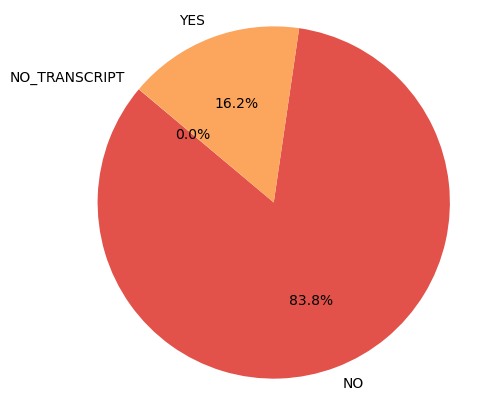

In [59]:
nmd_counts = lof_final_df['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(nmd_counts, 
        labels=nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.show()


In [60]:
# lof_final_df.to_csv('lof_final_df.csv', index=False)

### Разделение на NMD(+) и NMD(-) датафреймы

Делим на датафремы NMD_escaped и NMD:

In [61]:
nmd_esc_df = lof_final_df[lof_final_df['NMD_escape'] == 'YES']
nmd_df = lof_final_df[lof_final_df['NMD_escape'] == 'NO']

In [62]:
nmd_esc_df.shape  # избегают NMD

(2680, 17)

In [63]:
nmd_df.shape  # попадают под NMD

(13879, 17)

In [64]:
# nmd_esc_df.to_csv('nmd_esc_df.csv', index=False)
# nmd_df.to_csv('nmd_df.csv', index=False)

### Разделение вариантов по значению патогенности

Для начала создадим датафреймы для пат/непат (условно).

* **условно патогенные**  
   Отсечка в AC < 2. Плюс можно пересечь с ClinVar и записать в список варианты пат/лпат, которые отсутcтвуют в GnomAD v.4, но есть в ClinVar, так мы расширим список патов.
    
* **условно доброкачественные**  
  Отсечка в AC >= 2 (согласно свежим рекомендациям ACGS, критерий BS2). В таком случае у нас может остаться много АР вариантов, их я предлагаю убрать. Для этого можно полученный условно доброкачественный список сопоставить с ClinVar и удалить все пересечения с зарегистрированными пат/лпат вариантами.

В ClinVar не указаны транскрипты, поэтому проаннотируем скачанный файл Clinvar (версия для GRCh38) с помощью vep.  
`./vep -i ../clinvar/clinvar_20240331.vcf -o ../clinvar/clinvar_20240331_anno.vcf --vcf --canonical --cache`

#### Разделение по AC

Разнесём общий датафрейм (здесь `nmd_esc_df`) на `pat_nmd_escape` и `ben_nmd_escape`.

**Условно патогенные**:

In [65]:
pat_nmd_escape = nmd_esc_df.query('AC < 2')
pat_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
210760,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1,0.194,0.950938,YES
211245,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1,0.194,0.950938,YES
211254,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1,0.194,0.950938,YES
211258,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1,0.194,0.950938,YES
211278,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1,0.194,0.950938,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297779,chr22,43204096,.,G,T,HIGH,stop_gained,SCUBE1,ENST00000360835,2979,HC,NaN,NaN,1,0.313,0.920731,YES
1358300,chr22,44883208,.,C,A,HIGH,stop_gained,PHF21B,ENST00000313237,1930,HC,NaN,NaN,1,0.294,0.901950,YES
1358304,chr22,44883214,.,G,A,HIGH,stop_gained,PHF21B,ENST00000313237,1924,HC,NaN,NaN,1,0.294,0.901950,YES
1605180,chr22,50610725,.,C,G,HIGH,stop_gained,MAPK8IP2,ENST00000329492,2447,HC,NaN,NaN,1,0.100,1.000000,YES


**Условно доброкачественные**:

In [66]:
ben_nmd_escape = nmd_esc_df.query('AC >= 2')
ben_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
193676,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7,0.245,1.000000,YES
211250,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3,0.194,0.950938,YES
268094,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2,0.187,0.847792,YES
630109,chr1,12011511,rs1060501925,G,A,HIGH,stop_gained,MFN2,ENST00000235329,2410,HC,NaN,NaN,2,0.282,0.971272,YES
803217,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,HC,NaN,NaN,3,0.274,0.997337,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605913,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,HC,NaN,NaN,10,0.086,0.585560,YES
1092381,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6,0.202,0.996598,YES
1093303,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2,0.202,0.996598,YES
1175029,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2,0.323,0.988884,YES


#### Обработка датафрейма Clinvar

In [67]:
clinvar_df = pd.read_table('data_dir/clinvar/clinvar_20240331_anno.vcf.tsv')

In [68]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840143,chrNT_187693.1,273806,2219599,G,A,Likely_benign,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840144,chrNT_187693.1,273866,2237818,A,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840145,chrNT_187693.1,274366,2206666,G,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840146,chrNT_187693.1,275068,2241971,T,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026|LOC126057115:126057115,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавляем вариантам значение LOEUF и отбираем только условно высококонсервативные варианты:

In [69]:
clinvar_df.loc[:, 'LOEUF'] = clinvar_df['Feature'].map(loeuf_by_transcript_dict)

In [70]:
clinvar_df = clinvar_df.query('LOEUF < 0.35')

Добавляем метрику pext и отбираем только более экспрессирующиеся варианты:

In [71]:
for index, row in clinvar_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        clinvar_df.loc[index, 'pext'] = pext_dict[key]
    else:
        clinvar_df.loc[index, 'pext'] = None

/tmp/ipykernel_1417270/3120561689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_df.loc[index, 'pext'] = None


In [72]:
clinvar_df['pext'].notna().sum()

15299

In [73]:
clinvar_df['pext'] = clinvar_df['pext'].astype(float)
clinvar_df = clinvar_df[clinvar_df['pext'] > 0.5]

/tmp/ipykernel_1417270/3569552487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_df['pext'] = clinvar_df['pext'].astype(float)


In [74]:
clinvar_df['pext'].notna().sum()

10454

Оставим только варианты на каноническом транскрипте:

In [75]:
clinvar_canon_df = clinvar_df[clinvar_df['CANONICAL'] == 'YES']

Оставим только аутосомы:

In [76]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

In [77]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['CHROM'].isin(['chrMT', 'chrX', 'chrY', 'chrNT_113889.1'])]

In [78]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

Уберём строки, в которых нет информации о транскрипте или позиции кДНК:

In [79]:
clinvar_canon_df = clinvar_canon_df.dropna(subset=['cDNA_position', 'Feature'])

Оставим только однонуклеотидные варианты:

In [80]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['cDNA_position'].str.contains('-')]

Посмотрим, какие классы по клинической значимости у нас встречаются.

In [81]:
# clinvar_canon_df[clinvar_canon_df['CLNSIG'].str.contains('pathogenic', case=False, na=False)]['CLNSIG'].unique()

In [82]:
# clinvar_canon_df['Consequence'].unique()

In [83]:
# clinvar_canon_df['MC'].unique()

Оставим только стопгейны (в Clinvar - nonsense), отмеченные как пат/лпат.

In [84]:
clinvar_canon_df['CLNSIG'].isnull().sum()

0

In [85]:
# удаляем затесавшуюся строку с пустым значением CLNSIG
clinvar_canon_df = clinvar_canon_df.dropna(subset=['CLNSIG'])

In [86]:
# оставляем пат/лпат нонсенсы
clinvar_final_pat = clinvar_canon_df[
    clinvar_canon_df['CLNSIG'].str.contains('pathogenic') &
    ~clinvar_canon_df['CLNSIG'].str.contains('pathogenicity') &
    clinvar_canon_df['MC'].str.contains('nonsense') &
    clinvar_canon_df['Consequence'].str.contains('stop_gained')
]

clinvar_final_pat

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL,LOEUF,pext
102377,chr1,3412331,3062115,C,T,Likely_pathogenic,single_nucleotide_variant,PRDM16:63976,SO:0001587|nonsense,stop_gained,PRDM16,ENSG00000142611,Transcript,ENST00000270722,protein_coding,2191,YES,0.187,0.848889
104819,chr1,3426212,1805269,C,T,Likely_pathogenic,single_nucleotide_variant,PRDM16:63976,SO:0001587|nonsense,stop_gained,PRDM16,ENSG00000142611,Transcript,ENST00000270722,protein_coding,3328,YES,0.187,0.848889
107720,chr1,3722204,1192322,G,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,TP73:7161,SO:0001587|nonsense,stop_gained,TP73,ENSG00000078900,Transcript,ENST00000378295,protein_coding,772,YES,0.256,0.956129
131443,chr1,6124075,2444409,G,T,Likely_pathogenic,single_nucleotide_variant,CHD5:26038,SO:0001587|nonsense,stop_gained,CHD5,ENSG00000116254,Transcript,ENST00000262450,protein_coding,4870,YES,0.157,0.928222
131598,chr1,6126662,2691722,G,A,Likely_pathogenic,single_nucleotide_variant,CHD5:26038,SO:0001587|nonsense,stop_gained,CHD5,ENSG00000116254,Transcript,ENST00000262450,protein_coding,4286,YES,0.157,0.928222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33497124,chr22,50722235,422407,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4453,YES,0.123,1.000000
33497214,chr22,50722340,1177294,C,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4558,YES,0.123,1.000000
33497434,chr22,50730878,3024516,G,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4840,YES,0.123,1.000000
33497518,chr22,50730977,427096,A,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4939,YES,0.123,1.000000


In [87]:
clinvar_final_pat['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic/Likely_pathogenic'], dtype=object)

Расставим NMD(+) и NMD(-) и разделим датафреймы:

In [88]:
mask_transcript = clinvar_final_pat['Feature'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (clinvar_final_pat['Feature'] == transcript_split) & \
             (clinvar_final_pat['POS'] >= row['start']) & \
             (clinvar_final_pat['POS'] <= row['end'])
    
    clinvar_final_pat.loc[mask_all, 'NMD_escape'] = 'YES'


clinvar_final_pat.loc[(clinvar_final_pat['NMD_escape'] != 'YES') & (clinvar_final_pat['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

/tmp/ipykernel_1417270/84413560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'


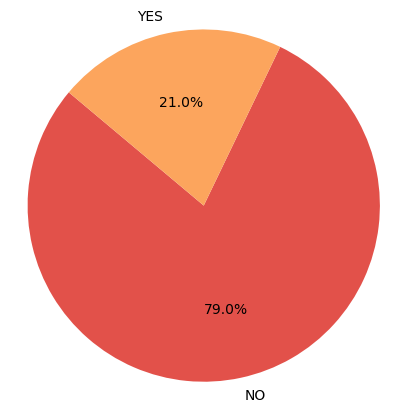

In [89]:
clinvar_nmd_counts = clinvar_final_pat['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(clinvar_nmd_counts, 
        labels=clinvar_nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.show()


Сделаем отдельные датафреймы для NMD(+) и NMD(-):

In [90]:
clinvar_nmd_esc_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'YES']
clinvar_nmd_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'NO']

#### Убираем из условно доброкачественных вариантов все паты Clinvar

Теперь пересечём `clinvar_nmd_esc_df` и `ben_nmd_escape` и оставим в последнем только те варианты, которых нет в `clinvar_nmd_esc_df`.

Соединим два датафрейма, удалим все пересечения по `'CHROM'`, `'POS'`, `'REF'`, `'ALT'`, и затем удалим остатки `clinvar_nmd_esc_df` (т.е. удалим все строки, у которых не пусто в столбце `CLNSIG`).

In [91]:
clinvar_nmd_esc = clinvar_nmd_esc_df.rename(columns={'Feature': 'Canonical_transcript'})

In [92]:
merged_clinvar_and_ben = pd.concat([ben_nmd_escape, clinvar_nmd_esc], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,12011511,rs1060501925,G,A,HIGH,stop_gained,MFN2,ENST00000235329,2410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,chr22,41178243,NaN,C,T,NaN,stop_gained,NaN,ENST00000263253,6945,...,2653214.0,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,EP300,ENSG00000100393,Transcript,protein_coding,YES
1037,chr22,41178579,NaN,C,T,NaN,stop_gained,NaN,ENST00000263253,7281,...,451064.0,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,EP300,ENSG00000100393,Transcript,protein_coding,YES
1038,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1039,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [93]:
# убираем дубликаты (если есть)
ben_nmd_escape_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,chr22,41178243,NaN,C,T,NaN,stop_gained,NaN,ENST00000263253,6945,...,2653214.0,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,EP300,ENSG00000100393,Transcript,protein_coding,YES
1037,chr22,41178579,NaN,C,T,NaN,stop_gained,NaN,ENST00000263253,7281,...,451064.0,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,EP300,ENSG00000100393,Transcript,protein_coding,YES
1038,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,3024516.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1039,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,427096.0,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [94]:
# убираем остатки клинвара
ben_nmd_escape_filtered = ben_nmd_escape_filtered[~ben_nmd_escape_filtered['CLNSIG'].notna()]
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
789,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
ben_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type',
       'BIOTYPE', 'CANONICAL'],
      dtype='object')

Убираем ненужны столбцы, оставшиеся после Клинвара.

In [96]:
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7.0,0.245,1.000000,YES
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3.0,0.194,0.950938,YES
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2.0,0.187,0.847792,YES
4,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,HC,NaN,NaN,3.0,0.274,0.997337,YES
5,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,HC,NaN,NaN,57.0,0.274,0.997337,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,HC,NaN,NaN,10.0,0.086,0.585560,YES
788,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,0.996598,YES
789,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2.0,0.202,0.996598,YES
790,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,0.988884,YES


Было вот так до фильтрации:

In [97]:
ben_nmd_escape.shape

(792, 17)

Добавим позицию в кодоне:

In [98]:
rows_to_remove = ben_nmd_escape_filtered[ben_nmd_escape_filtered['cDNA_position'].str.contains("-")].index
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(rows_to_remove)

ben_nmd_escape_filtered['cDNA_position'] = ben_nmd_escape_filtered['cDNA_position'].astype(int)

ben_nmd_escape_filtered['Codon_position'] = np.where(ben_nmd_escape_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_escape_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7.0,0.245,1.000000,YES,2
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3.0,0.194,0.950938,YES,2
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2.0,0.187,0.847792,YES,1
4,chr1,16251371,rs779190739,G,A,HIGH,stop_gained,FBXO42,ENST00000375592,1696,HC,NaN,NaN,3.0,0.274,0.997337,YES,1
5,chr1,16251562,rs532744461,G,T,HIGH,stop_gained,FBXO42,ENST00000375592,1505,HC,NaN,NaN,57.0,0.274,0.997337,YES,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,HC,NaN,NaN,10.0,0.086,0.585560,YES,1
788,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,0.996598,YES,2
789,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2.0,0.202,0.996598,YES,2
790,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,0.988884,YES,3


**Датафрейм с условно доброкачественными вариантами готов.**

#### Добавляем в условно патогенные варианты все непопуляционные паты Clinvar

Теперь добавим в `pat_nmd_escape` варианты, которые являются пат/лпат по ClinVar и при этом не встречаются в базе GnomAD v4.

In [99]:
pat_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
210760,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1,0.194,0.950938,YES
211245,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1,0.194,0.950938,YES
211254,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1,0.194,0.950938,YES
211258,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1,0.194,0.950938,YES
211278,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1,0.194,0.950938,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297779,chr22,43204096,.,G,T,HIGH,stop_gained,SCUBE1,ENST00000360835,2979,HC,NaN,NaN,1,0.313,0.920731,YES
1358300,chr22,44883208,.,C,A,HIGH,stop_gained,PHF21B,ENST00000313237,1930,HC,NaN,NaN,1,0.294,0.901950,YES
1358304,chr22,44883214,.,G,A,HIGH,stop_gained,PHF21B,ENST00000313237,1924,HC,NaN,NaN,1,0.294,0.901950,YES
1605180,chr22,50610725,.,C,G,HIGH,stop_gained,MAPK8IP2,ENST00000329492,2447,HC,NaN,NaN,1,0.100,1.000000,YES


In [100]:
clinvar_nmd_esc

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Canonical_transcript,BIOTYPE,cDNA_position,CANONICAL,LOEUF,pext,NMD_escape
354560,chr1,12009699,2682761,C,A,Likely_pathogenic,single_nucleotide_variant,MFN2:9927,SO:0001587|nonsense,stop_gained,MFN2,ENSG00000116688,Transcript,ENST00000235329,protein_coding,2367,YES,0.282,0.971272,YES
355319,chr1,12011511,1172816,G,A,Likely_pathogenic,single_nucleotide_variant,MFN2:9927,SO:0001587|nonsense,stop_gained,MFN2,ENSG00000116688,Transcript,ENST00000235329,protein_coding,2410,YES,0.282,0.971272,YES
539557,chr1,26780370,2637152,C,T,Likely_pathogenic,single_nucleotide_variant,ARID1A:8289,SO:0001587|nonsense,stop_gained,ARID1A,ENSG00000117713,Transcript,ENST00000324856,protein_coding,6861,YES,0.071,0.830723,YES
691537,chr1,42927241,449953,G,A,Likely_pathogenic,single_nucleotide_variant,SLC2A1:6513,SO:0001587|nonsense,stop_gained&splice_region_variant,SLC2A1,ENSG00000117394,Transcript,ENST00000426263,protein_coding,1496,YES,0.241,0.879101,YES
1444951,chr1,119915632,3049088,G,A,Likely_pathogenic,single_nucleotide_variant,NOTCH2:4853,SO:0001587|nonsense,stop_gained,NOTCH2,ENSG00000134250,Transcript,ENST00000256646,protein_coding,7346,YES,0.116,0.924443,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33238797,chr22,41178243,2653214,C,T,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,stop_gained,EP300,ENSG00000100393,Transcript,ENST00000263253,protein_coding,6945,YES,0.099,1.000000,YES
33239283,chr22,41178579,451064,C,T,Likely_pathogenic,single_nucleotide_variant,EP300:2033,SO:0001587|nonsense,stop_gained,EP300,ENSG00000100393,Transcript,ENST00000263253,protein_coding,7281,YES,0.099,1.000000,YES
33497434,chr22,50730878,3024516,G,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4840,YES,0.123,1.000000,YES
33497518,chr22,50730977,427096,A,T,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,SO:0001587|nonsense,stop_gained,SHANK3,ENSG00000251322,Transcript,ENST00000262795,protein_coding,4939,YES,0.123,1.000000,YES


In [101]:
pat_nmd_escape.shape[0] + clinvar_nmd_esc.shape[0]

2137

In [102]:
merged_clinvar_and_pat = pat_nmd_escape.merge(clinvar_nmd_esc, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2122,chr9,134842172,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771,YES,0.055,0.72251,YES,right_only


In [103]:
pat_nmd_escape_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2122,chr9,134842172,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771,YES,0.055,0.72251,YES,right_only


Проверим, остались ли дубликаты:

In [104]:
duplicates = pat_nmd_escape_filtered[pat_nmd_escape_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [105]:
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2122,chr9,134842172,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771,YES,0.055,0.72251,YES,right_only


In [106]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

Наводим красоту в шапке:

In [107]:
pat_nmd_escape_filtered['Canonical_transcript_x'] = pat_nmd_escape_filtered['Canonical_transcript_x'].fillna(pat_nmd_escape_filtered['Canonical_transcript_y'])
pat_nmd_escape_filtered['cDNA_position_x'] = pat_nmd_escape_filtered['cDNA_position_x'].fillna(pat_nmd_escape_filtered['cDNA_position_y'])
pat_nmd_escape_filtered['Consequence_x'] = pat_nmd_escape_filtered['Consequence_x'].fillna(pat_nmd_escape_filtered['Consequence_y'])
pat_nmd_escape_filtered['LOEUF_x'] = pat_nmd_escape_filtered['LOEUF_x'].fillna(pat_nmd_escape_filtered['LOEUF_y'])
pat_nmd_escape_filtered['Gene_symbol'] = pat_nmd_escape_filtered['Gene_symbol'].fillna(pat_nmd_escape_filtered['SYMBOL'])
pat_nmd_escape_filtered['NMD_escape_x'] = pat_nmd_escape_filtered['NMD_escape_x'].fillna(pat_nmd_escape_filtered['NMD_escape_y'])
pat_nmd_escape_filtered['pext_x'] = pat_nmd_escape_filtered['pext_x'].fillna(pat_nmd_escape_filtered['pext_y'])

pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2122,chr9,134842172,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5771,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771,YES,0.055,0.72251,YES,right_only


In [108]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL',
       'Gene', 'Feature_type', 'Canonical_transcript_y', 'BIOTYPE',
       'cDNA_position_y', 'CANONICAL', 'LOEUF_y', 'pext_y', 'NMD_escape_y',
       '_merge'],
      dtype='object')

In [109]:
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_escape_filtered = pat_nmd_escape_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1.0,0.194,0.950938,YES
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1.0,0.194,0.950938,YES
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1.0,0.194,0.950938,YES
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1.0,0.194,0.950938,YES
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1.0,0.194,0.950938,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,HC,NaN,NaN,1.0,0.118,0.787313,YES
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,HC,NaN,NaN,1.0,0.118,0.787313,YES
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,HC,NaN,NaN,1.0,0.341,0.546637,YES
2122,chr9,134842172,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5771,NaN,NaN,NaN,NaN,0.055,0.722510,YES


In [110]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Было без Клинвара вот так:

In [111]:
pat_nmd_escape.shape

(1888, 17)

Добавим позицию в кодоне:

In [112]:
rows_to_remove = pat_nmd_escape_filtered[pat_nmd_escape_filtered['cDNA_position'].str.contains("-")].index
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(rows_to_remove)

pat_nmd_escape_filtered['cDNA_position'] = pat_nmd_escape_filtered['cDNA_position'].astype(int)

pat_nmd_escape_filtered['Codon_position'] = np.where(pat_nmd_escape_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_escape_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1.0,0.194,0.950938,YES,3
1,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1.0,0.194,0.950938,YES,2
2,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1.0,0.194,0.950938,YES,2
3,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1.0,0.194,0.950938,YES,3
4,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1.0,0.194,0.950938,YES,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,chr9,132896423,.,G,A,HIGH,stop_gained,TSC1,ENST00000298552,3524,HC,NaN,NaN,1.0,0.118,0.787313,YES,2
2120,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,HC,NaN,NaN,1.0,0.118,0.787313,YES,2
2121,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,HC,NaN,NaN,1.0,0.341,0.546637,YES,1
2122,chr9,134842172,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5771,NaN,NaN,NaN,NaN,0.055,0.722510,YES,2


**Датафрейм с условно патогенными вариантами готов.**

### Сбалансируем датафреймы

Для этого в обоих дф оставим только те гены, которые встречаются и в пат, и в бен, а также уравняем количество вариантов в них.

In [113]:
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()

# Находим пересечение уникальных значений 'Gene_symbol'
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Всего уникальных генов в pat:", len(unique_genes_pat))
print("Всего уникальных генов в ben:", len(unique_genes_ben))
print("Количество пересекающихся генов:", len(intersected_genes))


Всего уникальных генов в pat: 720
Всего уникальных генов в ben: 442
Количество пересекающихся генов: 346


In [114]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

# Оставляем только те строки, где значение гена присутствует в обоих дф
ben_nmd_escape_filtered = ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_escape_filtered = pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]

In [115]:
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Всего уникальных генов в pat:", len(unique_genes_pat))
print("Всего уникальных генов в ben:", len(unique_genes_ben))
print("Количество пересекающихся генов:", len(intersected_genes))

Всего уникальных генов в pat: 346
Всего уникальных генов в ben: 346
Количество пересекающихся генов: 346


In [116]:
count_pat = pat_nmd_escape_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_escape_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_escape_final = pd.concat([
    pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_escape_final = pd.concat([
    ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [117]:
pat_nmd_escape_final.shape == ben_nmd_escape_final.shape

True

In [118]:
pat_nmd_escape_final['Gene_symbol'].nunique() == ben_nmd_escape_final['Gene_symbol'].nunique()

True

In [119]:
pat_nmd_escape_final['Gene_symbol'].value_counts().sum() == ben_nmd_escape_final['Gene_symbol'].value_counts().sum()

True

In [120]:
pat_nmd_escape_final['Gene_symbol'].nunique()

346

Теперь датафреймы сбалансированы по генам и количеству вариантов.

In [121]:
nmd_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
174506,chr1,1825438,rs867938404,G,A,HIGH,stop_gained,GNB1,ENST00000378609,379,HC,NaN,NaN,1,0.145,0.966547,NO
191152,chr1,2024966,.,C,A,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1,0.245,1.000000,NO
191153,chr1,2024966,.,C,G,HIGH,stop_gained,GABRD,ENST00000378585,172,HC,NaN,NaN,1,0.245,1.000000,NO
191172,chr1,2024993,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,199,HC,NaN,NaN,1,0.245,1.000000,NO
191594,chr1,2025553,.,G,A,HIGH,stop_gained,GABRD,ENST00000378585,364,HC,NaN,NaN,1,0.245,1.000000,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614606,chr22,50720939,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3157,HC,NaN,NaN,1,0.123,1.000000,NO
1614829,chr22,50721176,.,C,T,HIGH,stop_gained,SHANK3,ENST00000262795,3394,HC,NaN,NaN,1,0.123,1.000000,NO
1615180,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5,0.123,1.000000,NO
1615531,chr22,50721995,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,4213,HC,NaN,NaN,2,0.123,1.000000,NO


### Посмотрим на распределение кДНК позиций относительно начала и конца транскриптов

Получаем словарь с длинами транскриптов и записываем % расположение варианта в датафрейм:

In [122]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

In [123]:
transcript_lengths = {}
for key in transcript_fasta.keys():
    transcript_lengths[key] = len(transcript_fasta[key])

In [124]:
def check_and_divide(row):
    transcript = row['Canonical_transcript']
    if transcript in transcript_lengths:
        return (row['cDNA_position'] / transcript_lengths[transcript]) * 100
    return None

In [125]:
pat_nmd_escape_final['Percent_position'] = pat_nmd_escape_final.apply(check_and_divide, axis=1)

In [126]:
ben_nmd_escape_final['Percent_position'] = ben_nmd_escape_final.apply(check_and_divide, axis=1)

In [127]:
ben_nmd_escape_final.describe()

,POS,cDNA_position,AC,LOEUF,pext,Codon_position,Percent_position
count,6.040000e+02,604.000000,604.00000,604.000000,604.000000,604.000000,604.000000
mean,7.671407e+07,3735.009934,6.17053,0.247116,0.877152,1.922185,50.885332
std,5.413313e+07,3176.111125,14.17525,0.069587,0.139487,0.817859,21.690057
min,1.936840e+06,245.000000,2.00000,0.044000,0.506420,1.000000,4.173376
25%,3.367409e+07,1753.000000,2.00000,0.202750,0.813130,1.000000,33.152736
50%,6.411128e+07,2746.500000,3.00000,0.257000,0.927155,2.000000,50.962552
75%,1.102790e+08,4518.250000,5.00000,0.305000,0.998921,3.000000,68.266882
max,2.440554e+08,17875.000000,215.00000,0.349000,1.000000,3.000000,95.924890


In [128]:
ben_nmd_escape_final['Percent_position'].idxmin()

781

In [129]:
ben_nmd_escape_final.loc[560]

CHROM                             chr12
POS                           113463230
rsID                                  .
REF                                   G
ALT                                   T
Impact                             HIGH
Consequence                 stop_gained
Gene_symbol                        LHX5
Canonical_transcript    ENST00000261731
cDNA_position                      1542
LoF                                  HC
LoF_flag                            NaN
LoF_filter                          NaN
AC                                  3.0
LOEUF                             0.348
pext                                1.0
NMD_escape                          YES
Codon_position                        3
Percent_position              56.297919
Name: 560, dtype: object

In [130]:
transcript_lengths['ENST00000242310']

6216

Визуализируем распределение вариантов:

In [131]:
def extract_number(chrom):  # чтобы chr не мешало
    return int(chrom[3:])

In [132]:
pat_nmd_escape_final_sorted = pat_nmd_escape_final.copy()
pat_nmd_escape_final_sorted['CHROM'] = pat_nmd_escape_final_sorted['CHROM'].apply(extract_number)
pat_nmd_escape_final_sorted = pat_nmd_escape_final_sorted.sort_values(by='CHROM')

In [133]:
ben_nmd_escape_final_sorted = ben_nmd_escape_final.copy()
ben_nmd_escape_final_sorted['CHROM'] = ben_nmd_escape_final_sorted['CHROM'].apply(extract_number)
ben_nmd_escape_final_sorted = ben_nmd_escape_final_sorted.sort_values(by='CHROM')

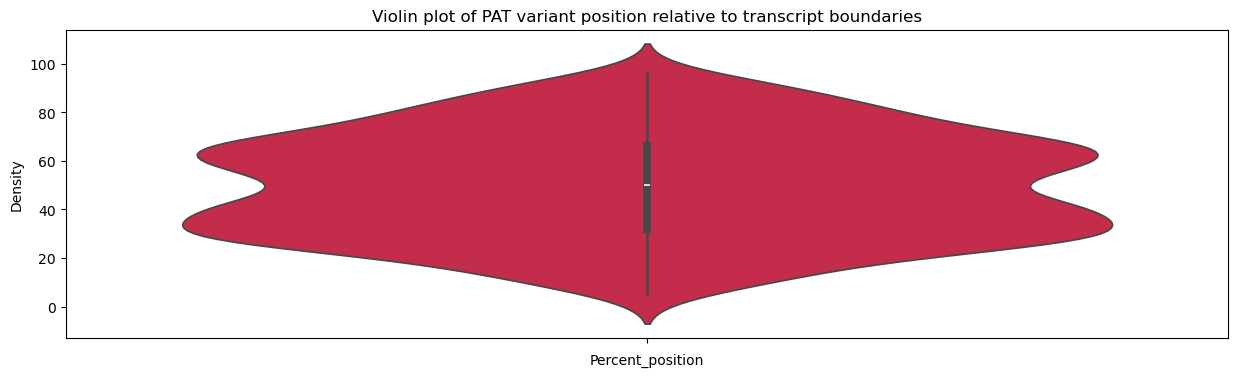

In [134]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

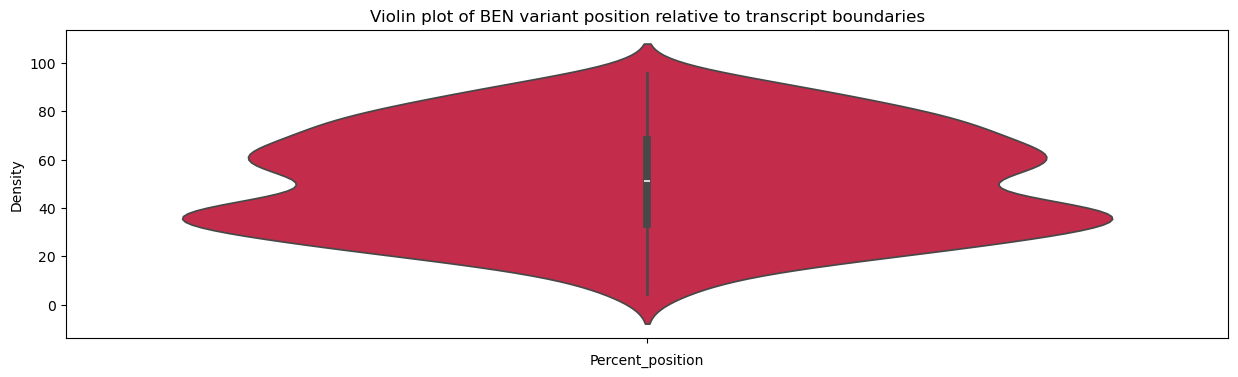

In [135]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

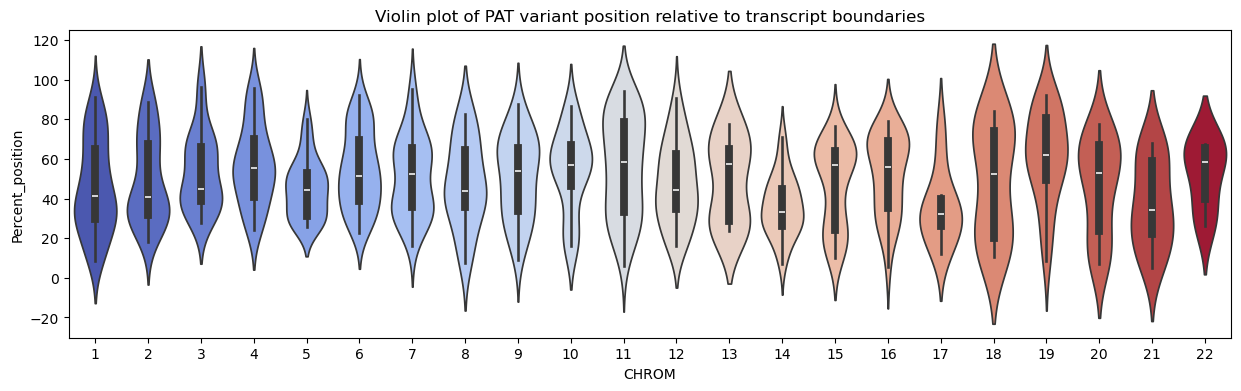

In [136]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

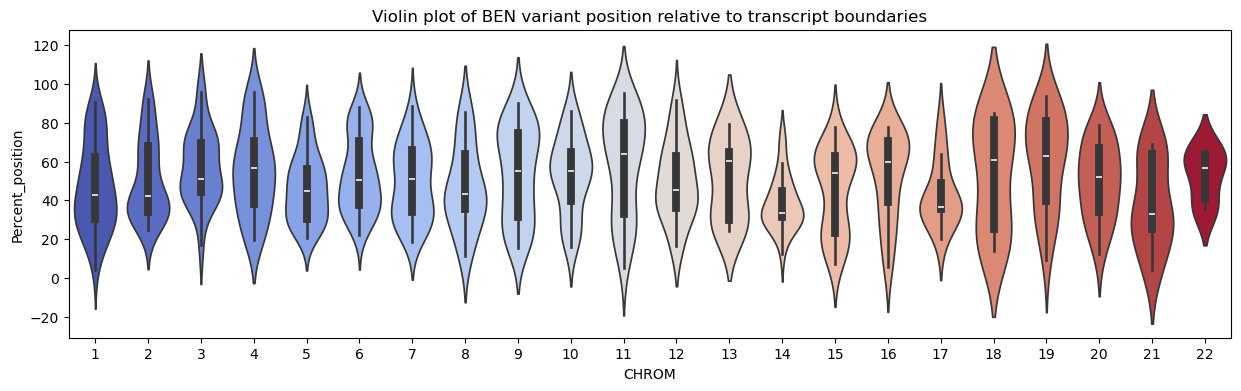

In [137]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

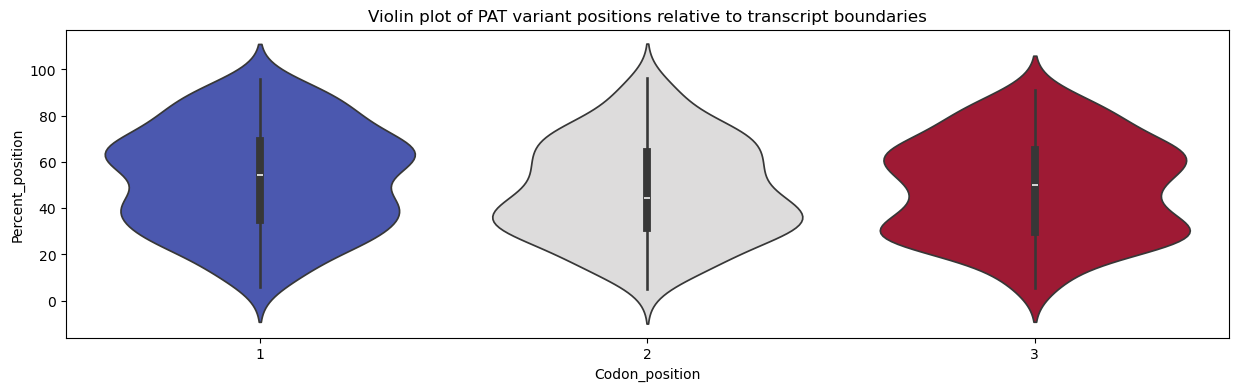

In [138]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

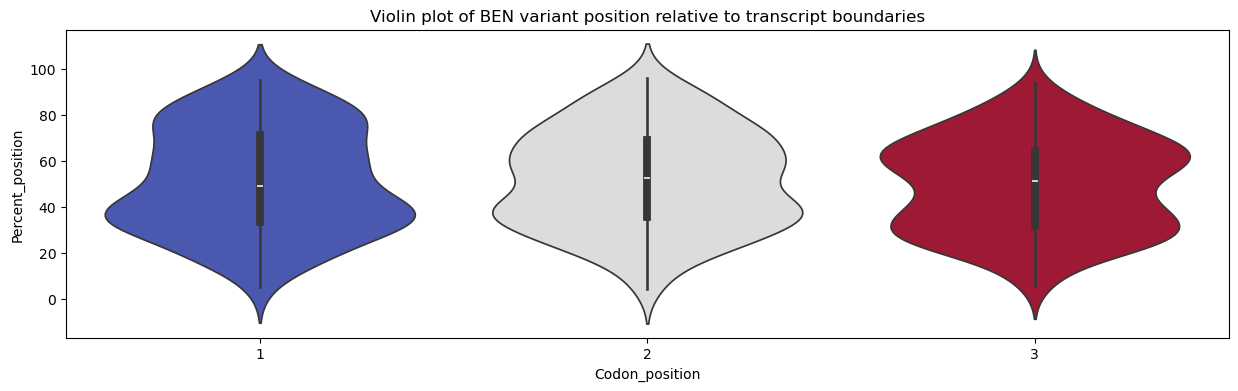

In [139]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

### Получение контекста последовательности

В таблице есть пустые поля в столбце `cDNA_position`, при итерации они отмечаются как `nan` (т.е. `<class 'float'>`). Если значение не пустое, оно имеет тип `str`, так что для работы `pyfaidx` приходится приводить его к `int`.

**Пропускаем позиции, которые слишком близко (`<=5`) к началу или концу транскрипта.**

Записываем контекст в отдельную колонку датафрейма.

In [140]:
def get_context(df, transcript_fasta, left_len, right_len):
    contexts = []

    for index, row in df.iterrows():
        transcript_id = row['Canonical_transcript']
        position_of_interest = row['cDNA_position']

        # Транскрипта может не быть в базе
        if transcript_id in transcript_fasta:
            transcript_length = len(transcript_fasta[transcript_id])

            # Не рассматриваем крайние случаи
            if left_len < position_of_interest < transcript_length - right_len:
                sequence_of_interest = str(transcript_fasta[transcript_id][position_of_interest - left_len: position_of_interest + right_len])
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None
        
        contexts.append(sequence_of_interest)

    df['Context'] = contexts
    message = 'Contexts have been added to the dataframe!'

    return message

In [141]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Разделим датафреймы по положению варианта в кодоне.

In [142]:
ben_nmd_escape_final_1 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 1].copy()
ben_nmd_escape_final_2 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 2].copy()
ben_nmd_escape_final_3 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 3].copy()

In [143]:
pat_nmd_escape_final_1 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 1].copy()
pat_nmd_escape_final_2 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 2].copy()
pat_nmd_escape_final_3 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 3].copy()

Получим контексты:

In [144]:
get_context(ben_nmd_escape_final_1, transcript_fasta, 5, 7)
get_context(ben_nmd_escape_final_2, transcript_fasta, 6, 6)
get_context(ben_nmd_escape_final_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

In [145]:
get_context(pat_nmd_escape_final_1, transcript_fasta, 5, 7)
get_context(pat_nmd_escape_final_2, transcript_fasta, 6, 6)
get_context(pat_nmd_escape_final_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

In [184]:
pat_nmd_escape_final_1

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context
308,chr11,62519050,rs763455961,C,A,HIGH,stop_gained,AHNAK,ENST00000378024,15613,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,1,83.220511,TCTGGAACTTTC
299,chr11,62517511,.,G,A,HIGH,stop_gained,AHNAK,ENST00000378024,17152,HC,NaN,NaN,1.0,0.308,0.821048,YES,1,91.423698,ACTCCAGGCTCC
324,chr11,62528413,rs1430023175,T,A,HIGH,stop_gained,AHNAK,ENST00000378024,6250,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,1,33.313789,CCCCAAAGTCAA
330,chr11,62533543,.,G,A,HIGH,stop_gained,AHNAK,ENST00000378024,1120,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,1,5.969831,GGTACAGGGCCC
301,chr11,62517529,.,C,A,HIGH,stop_gained,AHNAK,ENST00000378024,17134,HC,NaN,NaN,1.0,0.308,0.821048,YES,1,91.327754,GAAAGGAGGTCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,chr12,50475772,rs1458649255,C,T,HIGH,stop_gained,LARP4,ENST00000398473,2209,HC,NaN,NaN,1.0,0.345,0.903165,YES,1,34.295917,GGAACAGAGACG
469,chr12,108647506,.,A,T,HIGH,stop_gained,CORO1C,ENST00000261401,1417,HC,NaN,NaN,1.0,0.209,0.889840,YES,1,37.152596,AAGTTGGATGAG
1420,chr3,171066228,rs1718414686,G,A,HIGH,stop_gained,TNIK,ENST00000436636,4300,HC,NaN,NaN,1.0,0.181,0.651643,YES,1,43.469470,TAAGCGAGCTCA
484,chr12,120129296,.,G,A,HIGH,stop_gained,GCN1,ENST00000300648,7888,HC,NaN,NaN,1.0,0.208,0.784041,YES,1,90.865108,GCGGCAGGGTGA


In [189]:
# 437 индекс
transcript_fasta['ENST00000398473'][2209]  # индексация с 0

>ENST00000398473:2210-2210
A

In [190]:
# тогда:
transcript_fasta['ENST00000398473'][2209-1]

>ENST00000398473:2209-2209
C

In [188]:
transcript_fasta['ENST00000398473'][2209-5:2209+7]

>ENST00000398473:2205-2216
GGAACAGAGACG

In [194]:
pat_nmd_escape_final_2

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context
320,chr11,62526717,.,A,T,HIGH,stop_gained,AHNAK,ENST00000378024,7946,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,2,42.353819,TAAGTTAAAGAT
319,chr11,62524698,.,G,C,HIGH,stop_gained,AHNAK,ENST00000378024,9965,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,2,53.115506,TGTTTCACTTGC
307,chr11,62518551,rs750325349,G,C,HIGH,stop_gained,AHNAK,ENST00000378024,16112,HC,NaN,NaN,1.0,0.308,0.821048,YES,2,85.880284,GCCTTCAGTGAA
314,chr11,62521866,rs1940257828,C,T,HIGH,stop_gained,AHNAK,ENST00000378024,12797,LC,NaN,END_TRUNC,1.0,0.308,0.821048,YES,2,68.210650,AGACTGGCACTT
296,chr11,62517225,.,G,C,HIGH,stop_gained,AHNAK,ENST00000378024,17438,HC,NaN,NaN,1.0,0.308,0.821048,YES,2,92.948137,TGGCTCACCAGA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,chr4,153334880,.,C,T,HIGH,stop_gained,TRIM2,ENST00000338700,2318,HC,NaN,NaN,1.0,0.270,0.874223,YES,2,34.315322,GCCCCCAAGGCC
465,chr12,95659212,.,G,T,HIGH,stop_gained,NTN4,ENST00000343702,2216,HC,NaN,NaN,1.0,0.344,0.975997,YES,2,61.198564,GAATACCTTGTA
466,chr12,104103236,.,G,A,HIGH,stop_gained,HCFC2,ENST00000229330,2372,HC,NaN,NaN,1.0,0.198,0.582919,YES,2,41.908127,TCGGTGGCTTCA
1477,chr4,101029169,NaN,C,A,NaN,stop_gained,PPP3CA,ENST00000394854,2096,NaN,NaN,NaN,NaN,0.158,0.708371,YES,2,44.191440,CTGATGAAGCTA


In [196]:
# 1526 индекс
transcript_fasta['ENST00000338700'][2318 - 1]  # индексация с 0

>ENST00000338700:2318-2318
C

In [197]:
transcript_fasta['ENST00000338700'][2318 - 6 : 2318 + 6]  # индексация с 0

>ENST00000338700:2313-2324
GCCCCCAAGGCC

### Проверим, точно ли всё правильно сделали при обработке датафреймов

In [146]:
# pat_nmd_escape_final_1['Gene_symbol'].unique()

##### Выбрали рандомный ген:

In [147]:
pat_nmd_escape_final_1[pat_nmd_escape_final_1['Gene_symbol'] == 'MED1']

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position,Percent_position,Context


(здесь было два варианта, они исчезли после добавления pext)

##### Проверяем каждый вариант на соответствие контексту и чекаем всё ли ок в гномаде:

https://gnomad.broadinstitute.org/variant/17-39407762-G-A?dataset=gnomad_r4

In [148]:
transcript_fasta['ENST00000300651'][4660 - 5 : 4660 + 7]

>ENST00000300651:4656-4667
TATCCGACCACT

In [149]:
transcript_651 = transcript_fasta['ENST00000300651']

In [150]:
print(transcript_651[4660 - 5 : 4660 + 7])

TATCCGACCACT


https://gnomad.broadinstitute.org/variant/17-39409919-G-A?dataset=gnomad_r4

<font color="brown"> Здесь по ссылке стоит AC = 2, а у нас в таблице 1.  
В экзомах и правда 1 аллель, а ещё 1 в геномах.

In [151]:
transcript_fasta['ENST00000300651'][2503 - 5 : 2503 + 7]

>ENST00000300651:2499-2510
GGTCCGACTATC

In [152]:
print(transcript_651[2503 - 5 : 2503 + 7])

GGTCCGACTATC


##### Проверяем LOEUF в словаре и напрямую в сыром файле с plof_metrics:

In [153]:
loeuf_by_transcript_dict['ENST00000300651']

0.117

In [154]:
header_plof = [
    "gene", "transcript", "obs_mis", "exp_mis", "oe_mis", "mu_mis", "possible_mis",
    "obs_mis_pphen", "exp_mis_pphen", "oe_mis_pphen", "possible_mis_pphen", "obs_syn",
    "exp_syn", "oe_syn", "mu_syn", "possible_syn", "obs_lof", "mu_lof", "possible_lof",
    "exp_lof", "pLI", "pNull", "pRec", "oe_lof", "oe_syn_lower", "oe_syn_upper",
    "oe_mis_lower", "oe_mis_upper", "oe_lof_lower", "oe_lof_upper", "constraint_flag",
    "syn_z", "mis_z", "lof_z", "oe_lof_upper_rank", "oe_lof_upper_bin",
    "oe_lof_upper_bin_6", "n_sites", "classic_caf", "max_af", "no_lofs", "obs_het_lof",
    "obs_hom_lof", "defined", "p", "exp_hom_lof", "classic_caf_afr", "classic_caf_amr",
    "classic_caf_asj", "classic_caf_eas", "classic_caf_fin", "classic_caf_nfe",
    "classic_caf_oth", "classic_caf_sas", "p_afr", "p_amr", "p_asj", "p_eas", "p_fin",
    "p_nfe", "p_oth", "p_sas", "transcript_type", "gene_id", "transcript_level",
    "cds_length", "num_coding_exons", "gene_type", "gene_length", "exac_pLI",
    "exac_obs_lof", "exac_exp_lof", "exac_oe_lof", "brain_expression", "chromosome",
    "start_position", "end_position"
]

In [155]:
ENST00000300651_plof_df = pd.read_table("data_dir/ENST00000300651_plof.txt", names=header_plof)
ENST00000300651_plof_df['oe_lof_upper']
# oe_Lof_Upper: LOEUF: Upper bound of 90% confidence interval for o/e ratio for pLoF (predicted loss-of-function) variants. 

0    0.117
Name: oe_lof_upper, dtype: float64

##### Является ли NMD-escaped:

In [156]:
nmd_bed_df[nmd_bed_df['transcript'].str.contains('ENST00000300651')]

,chrom,start,end,cds_id,score,strand,transcript,cds_size
13951,chr17,39407477,39410721,ENST00000300651.11_cds_0_0_chr17_39407478_r,.,-,ENST00000300651.11,3244
13952,chr17,39415025,39415080,ENST00000300651.11_cds_0_0_chr17_39415026_r,.,-,ENST00000300651.11,55


In [157]:
( 39407477 <= 39407762 <= 39410721 ) or ( 39415025 <= 39407762 <= 39415080 )

True

In [158]:
( 39407477 <= 39409919 <= 39410721 ) or ( 39415025 <= 39409919 <= 39415080 )

True

##### Всё то же самое проделано для 2х вариантов в гене _SLIT3_, всё ок (не сохраняла, чтобы не засорять ноутбук).

### Построение лого с помощью logomaker

https://github.com/jbkinney/logomaker/blob/master/logomaker/tutorials

https://logomaker.readthedocs.io/en/latest/

Сам всё делает, надо только подать список последовательностей, удалив пустые значения.

In [159]:
def filter_and_convert_to_list(column):
    filtered_list = column.tolist()
    filtered_list = list(filter(None, filtered_list))
    return filtered_list

In [160]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_escape_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_escape_final_3['Context'])

In [161]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_escape_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_escape_final_3['Context'])

Строим матрицы.

[Text(0, 0, '-4'),
 Text(1, 0, '-3'),
 Text(2, 0, '-2'),
 Text(3, 0, '-1'),
 Text(4, 0, '+0'),
 Text(5, 0, '+1'),
 Text(6, 0, '+2'),
 Text(7, 0, '+3'),
 Text(8, 0, '+4'),
 Text(9, 0, '+5'),
 Text(10, 0, '+6'),
 Text(11, 0, '+7')]

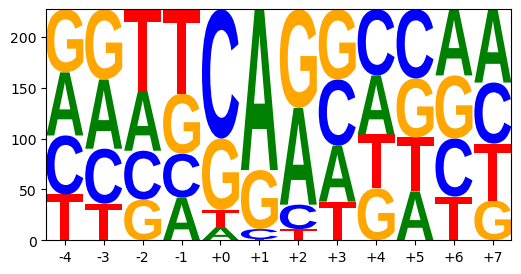

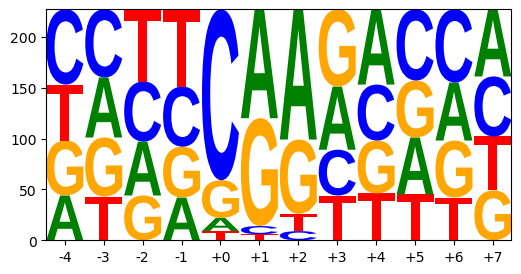

In [211]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])

ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])

[Text(0, 0, '-5'),
 Text(1, 0, '-4'),
 Text(2, 0, '-3'),
 Text(3, 0, '-2'),
 Text(4, 0, '-1'),
 Text(5, 0, '+0'),
 Text(6, 0, '+1'),
 Text(7, 0, '+2'),
 Text(8, 0, '+3'),
 Text(9, 0, '+4'),
 Text(10, 0, '+5'),
 Text(11, 0, '+6')]

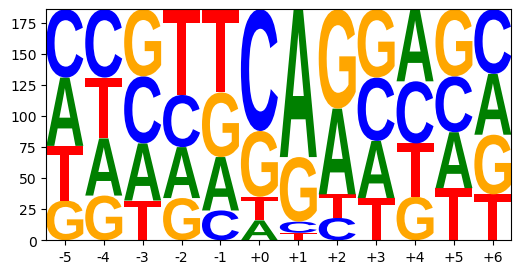

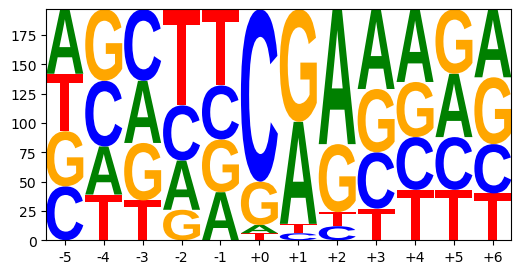

In [203]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])

ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])

[Text(0, 0, '-6'),
 Text(1, 0, '-5'),
 Text(2, 0, '-4'),
 Text(3, 0, '-3'),
 Text(4, 0, '-2'),
 Text(5, 0, '-1'),
 Text(6, 0, '+0'),
 Text(7, 0, '+1'),
 Text(8, 0, '+2'),
 Text(9, 0, '+3'),
 Text(10, 0, '+4'),
 Text(11, 0, '+5')]

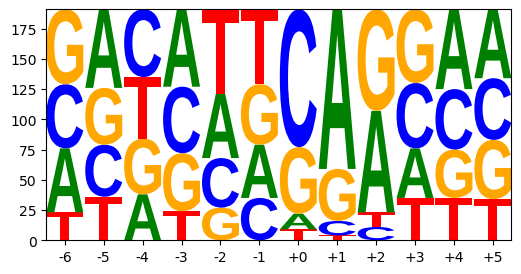

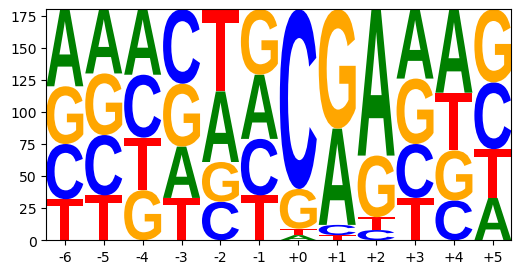

In [212]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])

Окрашивание по base_pairing:

In [165]:
# pat_logo = lm.Logo(counts_mat_pat, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# pat_logo.style_xticks()

# ben_logo = lm.Logo(counts_mat_ben, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# ben_logo.style_xticks()

Можно ещё по вероятностям строить:

In [166]:
# prob_mat_pat = lm.transform_matrix(counts_mat_pat, from_type='counts', to_type='probability')
# prob_mat_ben = lm.transform_matrix(counts_mat_ben, from_type='counts', to_type='probability')

**Ниже контекст для бОльшего количества букв:**

Text(0.5, 1.0, 'Benign context')

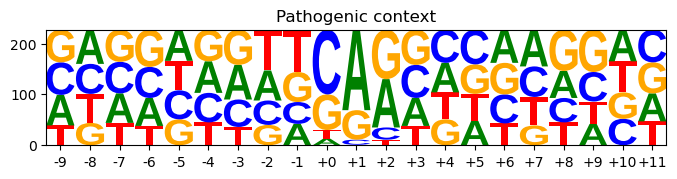

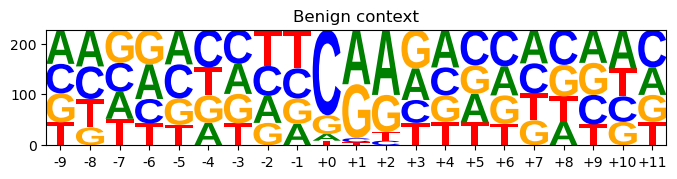

In [475]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')

counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')

Text(0.5, 1.0, 'Benign context')

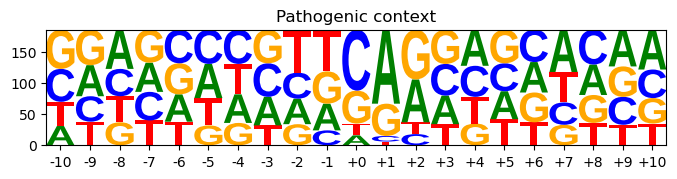

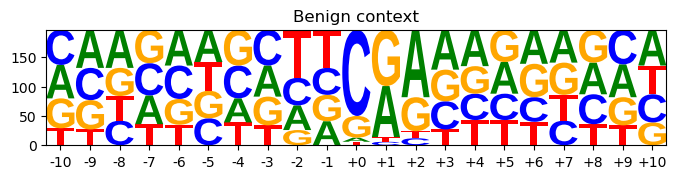

In [476]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
pat_logo = lm.Logo(counts_mat_pat_2, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
# pat_logo.ax.set_xticklabels('%+d'%x for x in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
pat_logo.ax.set_xticklabels('%+d'%x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)
ben_logo = lm.Logo(counts_mat_ben_2, 
                   figsize=(8, 1.5),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
# ben_logo.ax.set_xticklabels('%+d'%x for x in [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
ben_logo.ax.set_xticklabels('%+d'%x for x in [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ben_logo.ax.set_title('Benign context')

Text(0.5, 1.0, 'Benign context')

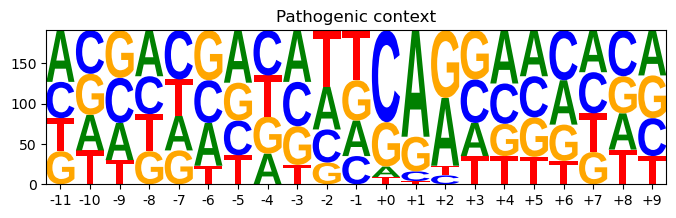

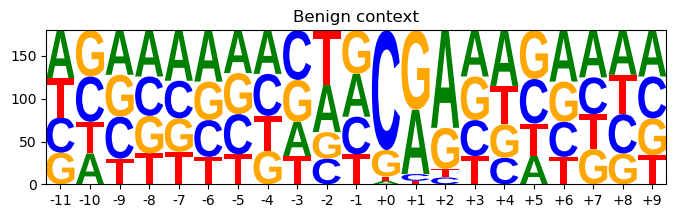

In [477]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
pat_logo = lm.Logo(counts_mat_pat_3, 
                   figsize=(8, 2),
                   font_name='Liberation Sans')
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)
ben_logo = lm.Logo(counts_mat_ben_3, 
                   figsize=(8, 2),
                   font_name='Liberation Sans')
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in [-11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ben_logo.ax.set_title('Benign context')

### Статистическое сравнение позиций в контекстах

Виды позиционных матриц:  

**Position Frequency Matrix (PFM)**:  
В ячейках PFM содержатся частоты каждого нуклеотида на соответствующей позиции в наборе последовательностей.
PFM не нормализуется по вероятностям, поэтому сумма значений в каждой строке может быть больше 1.  
  
**Position Probability Matrix (PPM)**:  
В отличие от PFM, значения в PPM нормализуются по вероятностям, так что сумма значений в каждой строке равна 1.
PPM показывает вероятность появления каждого нуклеотида на каждой позиции в последовательности.  

**Position Weight Matrix (PWM)**:  
Значения в PWM выражены в виде весов, которые показывают предпочтительность каждого нуклеотида на каждой позиции. Веса обычно вычисляются как логарифм отношения частоты наблюдения нуклеотида к ожидаемой частоте нуклеотида на данной позиции.

Считаем хи-квадраты для каждой позиции при сравнении двух матриц:

In [167]:
def calculate_chi2_p_values(context_ben, context_pat):
    # Преобразование списка контекстов в массив нампай
    sequences_array_ben = np.array(context_ben)
    sequences_array_pat = np.array(context_pat)

    # Создание пустого массива для хранения частот
    freq_array_ben = np.zeros((len(sequences_array_ben[0]), 4))
    freq_array_pat = np.zeros((len(sequences_array_pat[0]), 4))

    # Вычисление частоты каждой буквы на каждой позиции
    for seq in sequences_array_ben:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_ben[j][0] += 1
            elif nt == 'C':
                freq_array_ben[j][1] += 1
            elif nt == 'G':
                freq_array_ben[j][2] += 1
            elif nt == 'T':
                freq_array_ben[j][3] += 1

    for seq in sequences_array_pat:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_pat[j][0] += 1
            elif nt == 'C':
                freq_array_pat[j][1] += 1
            elif nt == 'G':
                freq_array_pat[j][2] += 1
            elif nt == 'T':
                freq_array_pat[j][3] += 1

    chi2_values = []
    p_values = []

    for i in range(freq_array_pat.shape[0]):
        # Таблица сопряженности для каждой текущей позиции (строки в массиве)
        contingency_table = np.array([freq_array_pat[i], freq_array_ben[i]])
        # Два пропуска, т.к. chi2_contingency возвращает statistic, pvalue, dof и expected_freq
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_values.append(chi2)
        p_values.append(p_value)

    return chi2_values, p_values


In [191]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 4:
        print("==="*25)
    if counter == 5:
        print("==="*25)

Position 0: Chi-square = 6.54772185090988, p-value = 0.08779935238599701
Position 1: Chi-square = 3.6074985605353573, p-value = 0.3070852113829063
Position 2: Chi-square = 2.1791697244596917, p-value = 0.5360629314062495
Position 3: Chi-square = 3.561099288252604, p-value = 0.31292377841396557
Position 4: Chi-square = 18.33741363974217, p-value = 0.0003747007911186751
Position 5: Chi-square = 27.657525621078314, p-value = 4.285675186618888e-06
Position 6: Chi-square = 16.375539469762632, p-value = 0.0009496584500613885
Position 7: Chi-square = 4.832122479893716, p-value = 0.18451085902154388
Position 8: Chi-square = 3.2773855055408454, p-value = 0.35080258399551933
Position 9: Chi-square = 1.3325190664190338, p-value = 0.721425966811212
Position 10: Chi-square = 2.585625662091119, p-value = 0.46001512857481186
Position 11: Chi-square = 1.488205370265015, p-value = 0.6849951880540526


In [192]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 5:
        print("==="*25)
    if counter == 6:
        print("==="*25)

Position 0: Chi-square = 3.6059462279032615, p-value = 0.3072789701660317
Position 1: Chi-square = 7.566342325374896, p-value = 0.05587811410888858
Position 2: Chi-square = 0.9091840283533832, p-value = 0.8232109449545951
Position 3: Chi-square = 2.1646777281345724, p-value = 0.5389392248737894
Position 4: Chi-square = 7.187364211131677, p-value = 0.06615964834891297
Position 5: Chi-square = 22.62892270083141, p-value = 4.825255639075341e-05
Position 6: Chi-square = 18.637115539641773, p-value = 0.00032493412786970406
Position 7: Chi-square = 17.486388719451938, p-value = 0.0005612526375748448
Position 8: Chi-square = 4.837039183263274, p-value = 0.18412631358931447
Position 9: Chi-square = 1.8381781621932303, p-value = 0.6066623887617382
Position 10: Chi-square = 0.5236258686115045, p-value = 0.9136710844107173
Position 11: Chi-square = 2.3951996672640803, p-value = 0.4945288286872581


In [193]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 6:
        print("==="*25)
    if counter == 7:
        print("==="*25)

Position 0: Chi-square = 5.3274946775665315, p-value = 0.14932821965405185
Position 1: Chi-square = 1.8343773856322358, p-value = 0.6074827571486088
Position 2: Chi-square = 3.7060826403553495, p-value = 0.2950009102224908
Position 3: Chi-square = 6.729239578113073, p-value = 0.08104728998008509
Position 4: Chi-square = 1.9613598505229497, p-value = 0.5804652199566578
Position 5: Chi-square = 8.615088045353032, p-value = 0.0348714010583656
Position 6: Chi-square = 14.953654950090081, p-value = 0.0018566853596856919
Position 7: Chi-square = 34.582260776949056, p-value = 1.4927196286506184e-07
Position 8: Chi-square = 14.705921157009609, p-value = 0.0020860118036598583
Position 9: Chi-square = 3.9079179330177922, p-value = 0.2715805400199842
Position 10: Chi-square = 5.405688519331335, p-value = 0.14438957564130148
Position 11: Chi-square = 6.915638520049726, p-value = 0.07463582548029826


**Ниже контекст для бОльшего количества букв:**

In [350]:
# chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
# counter = 0
# for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
#     print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
#     counter += 1
#     if counter == 4:
#         print("==="*25)
#     if counter == 5:
#         print("==="*25)

chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 9:
        print("==="*25)
    if counter == 10:
        print("==="*25)

Position 0: Chi-square = 1.5144388451240371, p-value = 0.678941884437873
Position 1: Chi-square = 1.4172741608465653, p-value = 0.701490614492775
Position 2: Chi-square = 1.1332259255053372, p-value = 0.7690598664913546
Position 3: Chi-square = 3.4103893952813777, p-value = 0.33257163401376133
Position 4: Chi-square = 4.5021277609872055, p-value = 0.21210057444245947
Position 5: Chi-square = 6.54772185090988, p-value = 0.08779935238599701
Position 6: Chi-square = 3.6074985605353573, p-value = 0.3070852113829063
Position 7: Chi-square = 2.1791697244596917, p-value = 0.5360629314062495
Position 8: Chi-square = 3.561099288252604, p-value = 0.31292377841396557
Position 9: Chi-square = 18.33741363974217, p-value = 0.0003747007911186751
Position 10: Chi-square = 27.657525621078314, p-value = 4.285675186618888e-06
Position 11: Chi-square = 16.375539469762632, p-value = 0.0009496584500613885
Position 12: Chi-square = 4.832122479893716, p-value = 0.18451085902154388
Position 13: Chi-square = 3.

In [351]:
# chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
# counter = 0
# for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
#     print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
#     counter += 1
#     if counter == 5:
#         print("==="*25)
#     if counter == 6:
#         print("==="*25)

chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 10:
        print("==="*25)
    if counter == 11:
        print("==="*25)

Position 0: Chi-square = 10.541961531614112, p-value = 0.014478932960969366
Position 1: Chi-square = 6.006698671546207, p-value = 0.11128477459524101
Position 2: Chi-square = 1.186342730462309, p-value = 0.7562817182595397
Position 3: Chi-square = 0.884430376951431, p-value = 0.8291833989569174
Position 4: Chi-square = 3.0262978507548617, p-value = 0.3875883100963327
Position 5: Chi-square = 3.6059462279032615, p-value = 0.3072789701660317
Position 6: Chi-square = 7.566342325374896, p-value = 0.05587811410888858
Position 7: Chi-square = 0.9091840283533832, p-value = 0.8232109449545951
Position 8: Chi-square = 2.1646777281345724, p-value = 0.5389392248737894
Position 9: Chi-square = 7.187364211131677, p-value = 0.06615964834891297
Position 10: Chi-square = 22.62892270083141, p-value = 4.825255639075341e-05
Position 11: Chi-square = 18.637115539641773, p-value = 0.00032493412786970406
Position 12: Chi-square = 17.486388719451938, p-value = 0.0005612526375748448
Position 13: Chi-square = 

In [352]:
# chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
# counter = 0
# for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
#     print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
#     counter += 1
#     if counter == 6:
#         print("==="*25)
#     if counter == 7:
#         print("==="*25)

chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 11:
        print("==="*25)
    if counter == 12:
        print("==="*25)

Position 0: Chi-square = 0.886498138573402, p-value = 0.8286848361411864
Position 1: Chi-square = 0.8861492362346857, p-value = 0.8287689654614098
Position 2: Chi-square = 1.4350555340098679, p-value = 0.6973384821710091
Position 3: Chi-square = 1.092042777950307, p-value = 0.7789953277843258
Position 4: Chi-square = 5.64247216723949, p-value = 0.13036123088928084
Position 5: Chi-square = 5.3274946775665315, p-value = 0.14932821965405185
Position 6: Chi-square = 1.8343773856322358, p-value = 0.6074827571486088
Position 7: Chi-square = 3.7060826403553495, p-value = 0.2950009102224908
Position 8: Chi-square = 6.729239578113073, p-value = 0.08104728998008509
Position 9: Chi-square = 1.9613598505229497, p-value = 0.5804652199566578
Position 10: Chi-square = 8.615088045353032, p-value = 0.0348714010583656
Position 11: Chi-square = 14.953654950090081, p-value = 0.0018566853596856919
Position 12: Chi-square = 34.582260776949056, p-value = 1.4927196286506184e-07
Position 13: Chi-square = 14.70

### Посмотрим на аминокислоты в округе

Краткий пример, что можно сделать по аминокислотам (например, для презентации?). Конечно, надо будет ещё навести красоту

In [225]:
transcript_fasta['ENST00000398473'][2209 - 10 : 2209 + 11]  # CAG  5|7 (1 позиция)

>ENST00000398473:2200-2220
ATCAGGGAACAGAGACGCCAG

In [226]:
from Bio.Seq import Seq

In [227]:
my_rna = Seq("ATCAGGGAACAGAGACGCCAG")
my_aa = my_rna.translate()
my_aa

Seq('IREQRRQ')

In [492]:
def translate_context(df_column):
    aa_column = []
    for context in df_column:
        if context is None:
            aa_column.append(None)
        else:
            sequence = Seq(context)
            aa_sequence = sequence.translate()
            aa_column.append(str(aa_sequence))
    return aa_column


In [493]:
pat_nmd_escape_final_1['AA_context'] = translate_context(pat_nmd_escape_final_1['Context'])

In [495]:
ben_nmd_escape_final_1['AA_context'] = translate_context(ben_nmd_escape_final_1['Context'])

In [496]:
filtered_aa_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['AA_context'])

In [497]:
filtered_aa_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['AA_context'])

Строим матрицы.

Text(0.5, 1.0, 'Benign context')

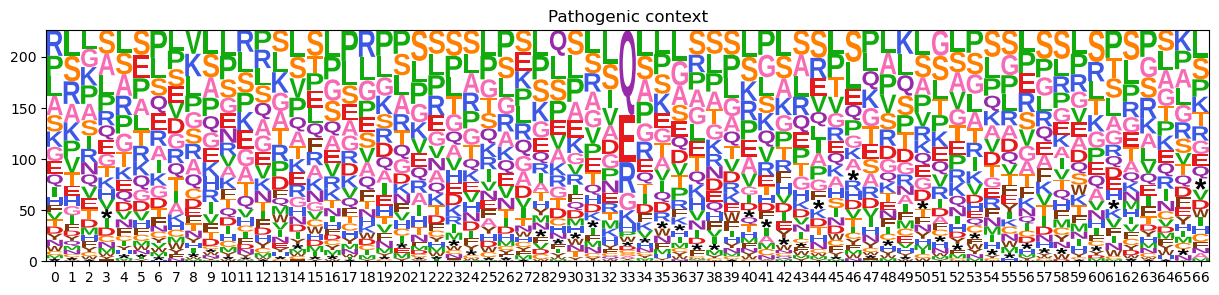

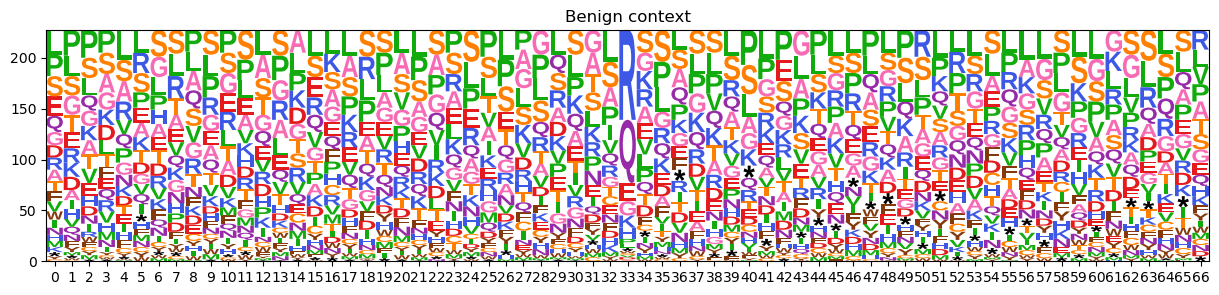

In [503]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_aa_context_pat_1)
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
pat_logo.style_xticks()
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#pat_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
pat_logo.ax.set_title('Pathogenic context')


counts_mat_ben_1 = lm.alignment_to_matrix(filtered_aa_context_ben_1)
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(15, 3),
                   font_name='Liberation Sans',
                   color_scheme='dmslogo_funcgroup')
ben_logo.style_xticks()
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7])
#ben_logo.ax.set_xticklabels('%+d'%x for x in [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ben_logo.ax.set_title('Benign context')